In [16]:
%load_ext autoreload
%autoreload 2

import itertools
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle
from tqdm import tqdm
from scipy import stats
import yaml

from graph_generation import GenerateGraph
from models import GCN
from train import Trainer, Dataset
from embedding import Embedding, NodeEmbedding
from experiments import (train_take_embedding, plot_dim1, plot_dimN, plot_correlation_error, 
                         get_metrics, init_GCN, init_model_dataset, train_take_embedding_alreadyinit)
from config_valid import Config, TrainingMode

import torch
from torch_geometric.loader import DataLoader
import tensorflow as tf

from deepdiff import DeepDiff

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
config_file = "configurations/classification_grid.yml"
config_c = Config(config_file)
gg = GenerateGraph(config_c)
dataset = gg.initialize_dataset()

Generating dataset...
Mean connectivity for each node: 14.933 p=0.05
Mean connectivity for each node: 89.705 p=0.3
Dataset generated


## Variabili per la grid search

In [3]:
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]

layers1 = [[1, 8, i] for i in range(2, 9, 6)]
layers1_2 = [[1, 16, i] for i in range(2, 17, 2)]
layers1_3 = [[1, 32, i] for i in range(2, 33, 2)]
layers2 = [[1, i, i, 1] for i in range(2, 100, 12)]
layers_nodense = [[1, i, 2] for i in range(2, 9, 1)]
#layers = layers_nodense

num_nodes = [260, 280, 300, 320, 340, 360]

epochs = [0, 1, 3, 10, 50, 5000]

## Creo il trials come prodotto di tutte le variabili in grid

In [4]:
#trials = list(itertools.product(learning_rates, layers, epochs))
#trials = list(itertools.product(layers1, layers1_2, layers1_3))
#print(len(trials))
#random.shuffle(trials)
trials = layers_nodense # + layers1_2 + layers1_3

In [5]:
import copy
def make_config(config, trials):
    configs = []
    #for lr, layer, num_nodes in trials:
    for layer in trials:
        #config['training']['learning_rate'] = lr
        
        config['model']['neurons_per_layer'] = layer
        #config['training']['epochs'] = epoch
        #config['graph_dataset']['Num_nodes'] = num_nodes
        copia = copy.deepcopy(config)
        confclass = Config.fromdict(copia)
        configs.append(confclass)
    return configs

In [6]:
configs2 = make_config(config_c.conf, trials)

In [14]:
# carica il master config
with open('configs_21-6-22.pickle', 'rb') as handle:
    configs = pickle.load(handle)

# check su run già fatti
actual_runs = []
for i, c2 in enumerate(configs2):
    cambi = True
    for j, c in enumerate(configs):
        ddiff = DeepDiff(c, c2.conf, ignore_order=False)
        cambi = ddiff.get('values_changed')
        if not cambi:
            print(f'salto i:{i} j:{j}')
            break    
    if cambi:
        actual_runs.append(c2)
        
print(len(actual_runs), len(configs2))

7 7


In [7]:
# nel caso in cui voglio ripetere comunque griglie già fatte
actual_runs = configs2

In [7]:
for i, c in enumerate(actual_runs):
    print(f'Run {i}/{len(actual_runs)}')
    for j in range(1):
        graph_embeddings_array, node_embeddings_array, model, test_loss_list, trainer = train_take_embedding(c, dataset)
        embeddings = Embedding(graph_embeddings_array, trainer.dataset, test_loss_list, config_c)
        num_emb_neurons = model.convs[-1].out_channels 
        embeddings.get_metrics(num_emb_neurons)
        
        #corrs, error = embeddings.calc_correlation()
        #c['correlations'] = corrs
        #c['error'] = error 
        c.conf['test_loss'] = test_loss_list
        c.conf['distance_of_means'] = embeddings.difference_of_means   # TODO: sarebbe il caso di mettere una gerarchia di chiavi anche per i risultati
        #c[f'run_num'] = j

Run 0/7
GCN(
  (convs): ModuleList(
    (0): GCNConv(1, 2)
    (1): GCNConv(2, 2)
  )
  (leakys): ModuleList(
    (0): LeakyReLU(negative_slope=0.03)
    (1): LeakyReLU(negative_slope=0.03)
  )
  (mean_pool): MeanAggregation()
  (drop): Dropout(p=0.5, inplace=False)
)
CrossEntropyLoss()
Loading Dataset...


  0%|                                                   | 0/600 [00:00<?, ?it/s]/home/daniele/Documenti/Progetti/Networks/Embednet/train.py:280: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  pyg_graph.y = torch.tensor([type_graph], dtype=tipo)
100%|█████████████████████████████████████████| 600/600 [00:41<00:00, 14.40it/s]


Tempo impiegato: 41.75770950317383
tensor([[0., 1.]], device='cuda:0') 420
tensor([[0., 1.]], device='cuda:0') 180
runs/lr-0.01_epochs58500_bs150_neurons-1-2-2_17Aug_21-50-18
Run training for 58500 epochs
Before training Test loss: 0.007801135712199741
Epoch: 0	Test loss: 0.007691524426142375
Epoch: 1000	Test loss: 0.007579530278841655
Epoch: 2000	Test loss: 0.007465919852256775
Epoch: 3000	Test loss: 0.007352138890160454
Epoch: 4000	Test loss: 0.00725118186738756
Epoch: 5000	Test loss: 0.00712641610039605
Epoch: 6000	Test loss: 0.006999300585852729
Epoch: 7000	Test loss: 0.006882138384713067
Epoch: 8000	Test loss: 0.006777836216820611
Epoch: 9000	Test loss: 0.006662422749731276
Epoch: 10000	Test loss: 0.0065651436646779375
Epoch: 11000	Test loss: 0.006454268097877502
Epoch: 12000	Test loss: 0.0063993473847707115
Epoch: 13000	Test loss: 0.00624929302268558
Epoch: 14000	Test loss: 0.006152474549081591
Epoch: 15000	Test loss: 0.006059433354271782
Epoch: 16000	Test loss: 0.005979464782608

100%|█████████████████████████████████████████| 600/600 [00:43<00:00, 13.90it/s]


Tempo impiegato: 43.253087759017944
tensor([[1., 0.]], device='cuda:0') 420
tensor([[0., 1.]], device='cuda:0') 180
runs/lr-0.01_epochs58500_bs150_neurons-1-3-2_17Aug_22-53-57
Run training for 58500 epochs
Before training Test loss: 0.007711956898371379
Epoch: 0	Test loss: 0.007693641384442647
Epoch: 1000	Test loss: 0.007599369353718228
Epoch: 2000	Test loss: 0.007480699486202664
Epoch: 3000	Test loss: 0.007339221901363797
Epoch: 4000	Test loss: 0.007243673337830437
Epoch: 5000	Test loss: 0.0071295032898585
Epoch: 6000	Test loss: 0.006997328003247579
Epoch: 7000	Test loss: 0.006914734178119235
Epoch: 8000	Test loss: 0.006780864463912116
Epoch: 9000	Test loss: 0.006674118836720784
Epoch: 10000	Test loss: 0.006551400820414225
Epoch: 11000	Test loss: 0.006434120734532674
Epoch: 12000	Test loss: 0.006367332405514187
Epoch: 13000	Test loss: 0.006242553061909146
Epoch: 14000	Test loss: 0.006142914295196533
Epoch: 15000	Test loss: 0.006120153268178304
Epoch: 16000	Test loss: 0.005970930722024

100%|█████████████████████████████████████████| 600/600 [00:42<00:00, 14.00it/s]


Tempo impiegato: 42.93897891044617
tensor([[1., 0.]], device='cuda:0') 420
tensor([[1., 0.]], device='cuda:0') 180
runs/lr-0.01_epochs58500_bs150_neurons-1-4-2_17Aug_23-59-20
Run training for 58500 epochs
Before training Test loss: 0.007511684629652235
Epoch: 0	Test loss: 0.007699246539009942
Epoch: 1000	Test loss: 0.006988884343041314
Epoch: 2000	Test loss: 0.006376923123995463
Epoch: 3000	Test loss: 0.00567740367518531
Epoch: 4000	Test loss: 0.004995759162637923
Epoch: 5000	Test loss: 0.004462640980879466
Epoch: 6000	Test loss: 0.004030279318491618
Epoch: 7000	Test loss: 0.0036528615487946402
Epoch: 8000	Test loss: 0.0031767737534311082
Epoch: 9000	Test loss: 0.002800783680544959
Epoch: 10000	Test loss: 0.002612529860602485
Epoch: 11000	Test loss: 0.002237350245316823
Epoch: 12000	Test loss: 0.0020335672630204093
Epoch: 13000	Test loss: 0.0017718346582518683
Epoch: 14000	Test loss: 0.0016128992040952046
Epoch: 15000	Test loss: 0.0014411444465319315
Epoch: 16000	Test loss: 0.001287144

100%|█████████████████████████████████████████| 600/600 [00:45<00:00, 13.14it/s]


Tempo impiegato: 45.721741676330566
tensor([[0., 1.]], device='cuda:0') 420
tensor([[0., 1.]], device='cuda:0') 180
runs/lr-0.01_epochs58500_bs150_neurons-1-5-2_18Aug_00-40-41
Run training for 58500 epochs
Before training Test loss: 0.007712085379494561
Epoch: 0	Test loss: 0.00771102507909139
Epoch: 1000	Test loss: 0.00040351090331872304
Early stopping!!!
Epoch: 1946	Test loss: 3.8575963117182255e-05 		 FINE TRAINING
Run 4/7
GCN(
  (convs): ModuleList(
    (0): GCNConv(1, 6)
    (1): GCNConv(6, 2)
  )
  (leakys): ModuleList(
    (0): LeakyReLU(negative_slope=0.03)
    (1): LeakyReLU(negative_slope=0.03)
  )
  (mean_pool): MeanAggregation()
  (drop): Dropout(p=0.5, inplace=False)
)
CrossEntropyLoss()
Loading Dataset...


100%|█████████████████████████████████████████| 600/600 [00:42<00:00, 14.26it/s]


Tempo impiegato: 42.15477514266968
tensor([[0., 1.]], device='cuda:0') 420
tensor([[0., 1.]], device='cuda:0') 180
runs/lr-0.01_epochs58500_bs150_neurons-1-6-2_18Aug_00-43-38
Run training for 58500 epochs
Before training Test loss: 0.008757673038376702
Epoch: 0	Test loss: 0.008462672432263693
Epoch: 1000	Test loss: 0.0073785808351304796
Epoch: 2000	Test loss: 0.0069686578379737005
Epoch: 3000	Test loss: 0.006548513637648689
Epoch: 4000	Test loss: 0.006157114439540439
Epoch: 5000	Test loss: 0.005778904755910238
Epoch: 6000	Test loss: 0.00544008496734831
Epoch: 7000	Test loss: 0.00507817053132587
Epoch: 8000	Test loss: 0.004777774877018399
Epoch: 9000	Test loss: 0.004465386437045203
Epoch: 10000	Test loss: 0.004196037352085113
Epoch: 11000	Test loss: 0.003917117416858673
Epoch: 12000	Test loss: 0.0036917487780253094
Epoch: 13000	Test loss: 0.003432091408305698
Epoch: 14000	Test loss: 0.003212029735247294
Epoch: 15000	Test loss: 0.003012268410788642
Epoch: 16000	Test loss: 0.0028351654609

100%|█████████████████████████████████████████| 600/600 [00:42<00:00, 13.96it/s]


Tempo impiegato: 43.07085108757019
tensor([[0., 1.]], device='cuda:0') 420
tensor([[1., 0.]], device='cuda:0') 180
runs/lr-0.01_epochs58500_bs150_neurons-1-7-2_18Aug_01-45-38
Run training for 58500 epochs
Before training Test loss: 0.007902808321846855
Epoch: 0	Test loss: 0.007814517948362562
Epoch: 1000	Test loss: 0.00013936059549450873
Early stopping!!!
Epoch: 1550	Test loss: 3.567139954409666e-05 		 FINE TRAINING
Run 6/7
GCN(
  (convs): ModuleList(
    (0): GCNConv(1, 8)
    (1): GCNConv(8, 2)
  )
  (leakys): ModuleList(
    (0): LeakyReLU(negative_slope=0.03)
    (1): LeakyReLU(negative_slope=0.03)
  )
  (mean_pool): MeanAggregation()
  (drop): Dropout(p=0.5, inplace=False)
)
CrossEntropyLoss()
Loading Dataset...


100%|█████████████████████████████████████████| 600/600 [00:43<00:00, 13.86it/s]


Tempo impiegato: 43.37988209724426
tensor([[1., 0.]], device='cuda:0') 420
tensor([[1., 0.]], device='cuda:0') 180
runs/lr-0.01_epochs58500_bs150_neurons-1-8-2_18Aug_01-48-15
Run training for 58500 epochs
Before training Test loss: 0.007725552717844645
Epoch: 0	Test loss: 0.0077346586518817475
Epoch: 1000	Test loss: 0.007615473535325792
Epoch: 2000	Test loss: 0.007483845618036058
Epoch: 3000	Test loss: 0.0073991590076022675
Epoch: 4000	Test loss: 0.007249383793936835
Epoch: 5000	Test loss: 0.007123546467887031
Epoch: 6000	Test loss: 0.007026803824636671
Epoch: 7000	Test loss: 0.0069094124767515395
Epoch: 8000	Test loss: 0.006808932953410679
Epoch: 9000	Test loss: 0.006715227166811625
Epoch: 10000	Test loss: 0.00658344394630856
Epoch: 11000	Test loss: 0.006493338942527771
Epoch: 12000	Test loss: 0.006404698888460795
Epoch: 13000	Test loss: 0.006272824274169074
Epoch: 14000	Test loss: 0.00617293549908532
Epoch: 15000	Test loss: 0.006068763468000624
Epoch: 16000	Test loss: 0.0059838225444

In [ ]:
# stampare il modello da mettere nel poster
#- rifare il forward a mano con i pesi per verificare di poter ricostruire la rete (solo LSTM (-> per mio progetto GNN su trained neural networks) o anche GNN?)

In [23]:
for name, param in trainer.model.named_parameters():
    print(name, param)
    print(param.view(-1))
    print("\n")

convs.0.bias Parameter containing:
tensor([ 0.1445, -0.1000,  0.1519,  0.0644], device='cuda:0',
       requires_grad=True)
tensor([ 0.1445, -0.1000,  0.1519,  0.0644], device='cuda:0',
       grad_fn=<ViewBackward0>)


convs.0.lin.weight Parameter containing:
tensor([[-0.5883],
        [-0.0494],
        [-0.4230],
        [-0.5811]], device='cuda:0', requires_grad=True)
tensor([-0.5883, -0.0494, -0.4230, -0.5811], device='cuda:0',
       grad_fn=<ViewBackward0>)


lin.weight Parameter containing:
tensor([[-0.0254,  0.0227, -0.0413,  0.2520]], device='cuda:0',
       requires_grad=True)
tensor([-0.0254,  0.0227, -0.0413,  0.2520], device='cuda:0',
       grad_fn=<ViewBackward0>)


lin.bias Parameter containing:
tensor([0.1767], device='cuda:0', requires_grad=True)
tensor([0.1767], device='cuda:0', grad_fn=<ViewBackward0>)




0.0102240965

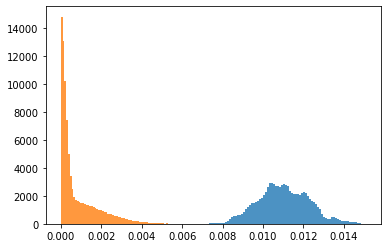

In [10]:
#plt.plot(embeddings.embeddings_array);
plt.hist(embeddings.inter_dists, bins=80, alpha=0.8)
plt.hist(embeddings.intra_dists, bins=80, alpha=0.8)
    
mean_intra = np.mean(embeddings.intra_dists)
mean_inter = np.mean(embeddings.inter_dists)
distance_of_means = mean_inter - mean_intra
distance_of_means

# 0 epoch training

In [10]:
config_file = "configurations/classification_0training.yml"
config_c = Config(config_file)
gg = GenerateGraph(config_c)
dataset = gg.initialize_dataset()

Generating dataset...


/home/daniele/Documenti/Progetti/Networks/Embednet/graph_generation.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grafi_actual_degrees = np.array(grafi_actual_degrees)


Dataset generated


In [27]:
trials = [[1, i, 1, 2] for i in range(2, 4, 1)]
configs2 = make_config(config_c.conf, trials)
# salto la parte che guarda i run passati, nel caso in cui voglio ripetere comunque griglie già fatte
actual_runs = configs2

In [22]:
model, trainer = init_model_dataset(actual_runs[0], dataset, verbose=False)

Initialize model
Loading Dataset...


100%|███████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.06it/s]


Tempo impiegato: 10.47242784500122


In [46]:
node_emb_tot = []
for i, c in enumerate(actual_runs):
    print(f'Run {i}/{len(actual_runs)}')
    for j in range(3):
        model = init_GCN(c, verbose=False)
        graph_embeddings_array, node_embeddings_array, model, test_loss_list, trainer = train_take_embedding_alreadyinit(trainer, model, c)
        #embeddings = Embedding(graph_embeddings_array, trainer.dataset, test_loss_list, config_c)
        node_embeddings = NodeEmbedding(node_embeddings_array, trainer.dataset, test_loss_list, c)
        node_emb_tot.append(node_embeddings)
        c.conf['average_corr_emb_degree'] = node_embeddings.get_average_corr_nodeemb()
        c.conf['run number'] = f"{i}_{j}"

Run 0/2
Before training Test loss: 0.0046264906724294026
[-0.00111513 -0.00128041 -0.00094419 -0.00168711 -0.00096982 -0.00119759
 -0.00111324 -0.00109453 -0.00219756 -0.00097726]
[2, 2, 1, 5, 1, 2, 2, 2, 9, 1]
-0.9874191634515149
Before training Test loss: 0.0051622821887334185
[0.02794908 0.03209165 0.02366465 0.04228488 0.02430708 0.03001577
 0.02790158 0.02743261 0.05507848 0.02449342]
[2, 2, 1, 5, 1, 2, 2, 2, 9, 1]
0.9874191626697485
Before training Test loss: 0.005666576027870178
[0.23021968 0.26434237 0.19492832 0.34830523 0.20022002 0.24724318
 0.22982836 0.22596541 0.45368746 0.20175499]
[2, 2, 1, 5, 1, 2, 2, 2, 9, 1]
0.9874191835231053
Run 1/2
Before training Test loss: 0.004578574697176615
[0.5175058  0.5942095  0.4381751  0.78294766 0.45007014 0.55577254
 0.5166261  0.50794274 1.019834   0.45352054]
[2, 2, 1, 5, 1, 2, 2, 2, 9, 1]
0.9874191674388687
Before training Test loss: 0.004887856841087342
[-0.01321305 -0.01517146 -0.01118756 -0.01999036 -0.01149127 -0.01419008
 -0.01

In [53]:
embs_pergraph = [n.get_emb_pergraph() for n in node_emb_tot]
#embs_pergraph = [n.node_emb_pergraph for n in node_emb_tot]

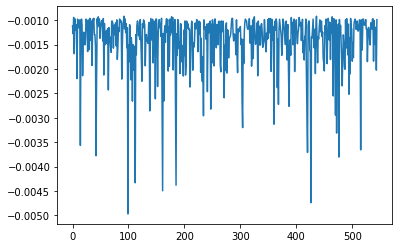

In [58]:
plt.plot(embs_pergraph[0][0].flatten())

# Save

In [20]:
def config2df(dati_c):
    # dati_c è una lista di Config
    dati = [d.conf for d in dati_c]
    df_data = pd.DataFrame(columns=['range_p', 'Num_nodes', 'Num_grafi_totali', 'learning_rate', 'batch_size', 'neurons_per_layer', 'correlations', 'error', 'test_loss', 'distance_of_means', 'batch_norm'])
    df_data['range_p'] = [d['graph_dataset']['range_p'] for d in dati]
    df_data['Num_nodes'] = [d['graph_dataset']['Num_nodes'] for d in dati]
    df_data['Num_grafi_totali'] = [d['graph_dataset']['Num_grafi_totali'] for d in dati]
    df_data['learning_rate'] = [d['training']['learning_rate'] for d in dati]
    df_data['batch_size'] = [d['training']['batch_size'] for d in dati]
    df_data['neurons_per_layer'] = [d['model']['neurons_per_layer'] for d in dati]
    df_data['correlations'] = [d.get('correlations') for d in dati]
    df_data['error'] = [d.get('error') for d in dati]
    df_data['test_loss'] = [[round(l, 10) for l in d.get('test_loss') or []] for d in dati ]  # or [] : per il caso in cui d.get restituisca None
    df_data['distance_of_means'] = [d.get('distance_of_means') for d in dati]  # caso della classification
    #df_data['run_num'] = [d.get('run_num') for d in dati]
    df_data['batch_norm'] = [d['model']['put_batchnorm'] for d in dati]
    df_data['num_epochs'] = [d['training']['epochs'] for d in dati]
    df_data['run_number'] = [d.get('run number') for d in dati] 
    df_data['average_corr_emb_degree'] = [d.get('average_corr_emb_degree') for d in dati]
    return df_data

In [15]:
# correggo il dataframe esistente aggiungendo i campi che mi viene in mente di aggiungere nel tempo
file = "df_configs_class.csv" #"df_configs.csv" #
df_data = pd.read_csv(file)  
df_data['num_epochs'] = 5000
df_data.to_csv(file) 

In [9]:
df_data = config2df(actual_runs)

In [10]:
df_data

,range_p,Num_nodes,Num_grafi_totali,learning_rate,batch_size,neurons_per_layer,correlations,error,test_loss,distance_of_means,batch_norm,num_epochs
0,"[0.05, 0.6]",300,1000,0.01,150,"[1, 2, 2]",None,None,"[0.0076915244, 0.0076874074, 0.0076981409, 0.0...",1.617932,False,58500
1,"[0.05, 0.6]",300,1000,0.01,150,"[1, 3, 2]",None,None,"[0.0076936414, 0.0076953024, 0.0077053282, 0.0...",1.680985,False,58500
2,"[0.05, 0.6]",300,1000,0.01,150,"[1, 4, 2]",None,None,"[0.0076992465, 0.0077066571, 0.0077103025, 0.0...",7.681736,False,58500
3,"[0.05, 0.6]",300,1000,0.01,150,"[1, 5, 2]",None,None,"[0.0077110251, 0.0077104641, 0.0077109204, 0.0...",7.885417,False,58500
4,"[0.05, 0.6]",300,1000,0.01,150,"[1, 6, 2]",None,None,"[0.0084626724, 0.0082711991, 0.0081168347, 0.0...",7.368047,False,58500
5,"[0.05, 0.6]",300,1000,0.01,150,"[1, 7, 2]",None,None,"[0.0078145179, 0.0077558074, 0.0077226741, 0.0...",7.908820,False,58500
6,"[0.05, 0.6]",300,1000,0.01,150,"[1, 8, 2]",None,None,"[0.0077346587, 0.0077183266, 0.0077100694, 0.0...",1.685347,False,58500


In [11]:
import os
outfile = "df_configs_class_longrun.csv" #"df_configs.csv" #
df_data.to_csv(outfile, index=False, mode='a', header=not os.path.exists(outfile))

In [30]:
# aggiungo al master config
configs.extend(actual_runs)

In [33]:
for c in configs:
    if c.get('test_loss'):
        del c['test_loss']

In [34]:
with open('configs_21-6-22.pickle', 'wb') as handle:
    pickle.dump(configs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
df_data = config2df(actual_runs)
df_data

,range_p,Num_nodes,Num_grafi_totali,learning_rate,batch_size,neurons_per_layer,correlations,error,test_loss,distance_of_means,batch_norm,num_epochs,run_number,average_corr_emb_degree
0,"[0.05, 0.6]","[600, 100000]",1000,0.01,250,"[1, 2, 1, 2]",None,None,[],None,False,0,0_9,-0.00107
1,"[0.05, 0.6]","[600, 100000]",1000,0.01,250,"[1, 3, 1, 2]",None,None,[],None,False,0,1_9,-0.00107
2,"[0.05, 0.6]","[600, 100000]",1000,0.01,250,"[1, 4, 1, 2]",None,None,[],None,False,0,2_9,-0.00107
3,"[0.05, 0.6]","[600, 100000]",1000,0.01,250,"[1, 5, 1, 2]",None,None,[],None,False,0,3_9,0.00107
4,"[0.05, 0.6]","[600, 100000]",1000,0.01,250,"[1, 6, 1, 2]",None,None,[],None,False,0,4_9,-0.00107
5,"[0.05, 0.6]","[600, 100000]",1000,0.01,250,"[1, 7, 1, 2]",None,None,[],None,False,0,5_9,0.00107
6,"[0.05, 0.6]","[600, 100000]",1000,0.01,250,"[1, 8, 1, 2]",None,None,[],None,False,0,6_9,-0.00107
